In [1]:
# Import Dependencies and modules
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from string import punctuation
from collections import Counter
from io import StringIO
from nltk.corpus import stopwords
import nltk
import glob
import errno
import os
import json
import pickle
import en_core_web_md
from spacy import displacy
import gensim
from itertools import chain
from gensim import models, corpora, similarities
from gensim.models import CoherenceModel, TfidfModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from spacy.lang.en import English
import math

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset

# Load Data

In [2]:
# Load each json file
with open('iphonex_digtrends.json') as f:
    iphonex_digtrends = json.load(f)

with open('iphonex_gizmodo.json') as f:
    iphonex_gizmodo = json.load(f)

with open('iphonex_techradar.json') as f:
    iphonex_techradar = json.load(f)

with open('S9_digtrends.json') as f:
    S9_digtrends = json.load(f)

with open('S9_gizmodo.json') as f:
    S9_gizmodo = json.load(f)

with open('S9_techradar.json') as f:
    S9_techradar = json.load(f)

# Clean Data

In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!

    text = str(text).replace("\n", "")
    text = str(text).replace("\t", "")
    text = str(text).replace("\\n", "")
    text = str(text).replace("\\t", "")
    text = str(text).replace("\\", "")
    text = str(text).replace("xa0", " ")
    text = str(text).replace("\'", "")
    text = re.sub("<p>", "", str(text))
    text = re.sub("</p>", "", str(text))
    text = re.sub("</a>", "", str(text))
    text = re.sub('<[^>]+>', "", str(text))
    text = str(text).replace("\\u2019", "")
    text = str(text).replace("\\u2013", "")
    text = str(text).replace("\\u2018", "")
    text = str(text).replace("\\u00a0", "")
    text = str(text).replace("\\u00a3", "")
    text = str(text).replace("\u2014", "")
    text = str(text).replace("\u201d", "")
    text = str(text).replace("\u201c", "")
    return text


In [4]:
# Populate each JSON file into a data frame

iphonex_digtrends = pd.DataFrame.from_dict(iphonex_digtrends, orient='columns')
iphonex_gizmodo = pd.DataFrame.from_dict(iphonex_gizmodo, orient='columns')
iphonex_techradar = pd.DataFrame.from_dict(iphonex_techradar, orient='columns')
S9_digtrends = pd.DataFrame.from_dict(S9_digtrends, orient='columns')
S9_gizmodo = pd.DataFrame.from_dict(S9_gizmodo, orient='columns')
S9_techradar = pd.DataFrame.from_dict(S9_techradar, orient='columns')

In [5]:
# Define function to clean text
def clean_text(df):
    # Convert lists to strings and remove brackets
    df['text'] = df['text'].astype(str)
    df['author'] = df['author'].astype(str)

    df['text'] = df['text'].map(lambda x: x.strip('[]'))
    df['author'] = df['author'].map(lambda x: x.strip('[]'))

    # Clean text
    df['text'] = df['text'].apply(lambda x: text_cleaner(x))
    df['title'] = df['title'].apply(lambda x: text_cleaner(x))
    df['author'] = df['author'].apply(lambda x: text_cleaner(x))

    
# Put dataframes into a list to iterate through
dataframes = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar, S9_digtrends, S9_gizmodo, S9_techradar]

# Clean each Data Frame
for dataframe in dataframes:
    clean_text(dataframe)

In [6]:
# Label all the rows in the dataframe with the type of phone discussed in text

iphones = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar]
s9s = [S9_digtrends, S9_gizmodo, S9_techradar]

for dataframe in iphones:
    dataframe['phone'] = 'IPhone X'
    
for dataframe in s9s:
    dataframe['phone'] = 'Samsung Galaxy S9'


In [7]:
# Concat all the dataframes into one dataframe
all_frames = [iphonex_digtrends, iphonex_gizmodo, iphonex_techradar, S9_digtrends, S9_gizmodo, S9_techradar]
df = pd.concat(all_frames)


In [8]:
# Visualize dataframe
df.head()

,author,text,title,phone
0,Eric Brackett,The iPhone X launched to stellar reviews and e...,Shrinking demand forces Apple to slow down iPh...,IPhone X
1,Lucas Coll,"When it comes to high-quality devices, like th...",Looking to upgrade? These are the best iPhone ...,IPhone X
2,Simon Hill,The iPhone X is completely different from any ...,"The most common iPhone X problems, and how to ...",IPhone X
3,Trevor Mogg,"If you’re in the market for an iPhone X, and p...","This $4,600 solar charger comes with an iPhone...",IPhone X
4,Mark Jansen,", The initial estimates, set during the Novemb...",Apple will halve iPhone X production after lim...,IPhone X


# Load all Pre-Trained Models

In [9]:
# Load Opinion Lexicon
negatives = open('negative-words.txt', encoding = 'latin-1')
positives = open('positive-words.txt', encoding = 'latin-1')

# Read file
neg_unedit = [line.strip() for line in negatives.readlines()]
pos_unedit = [line.strip() for line in positives.readlines()]

# Extract only the list of words in the lexicon
neg = neg_unedit[31:]
pos = pos_unedit[30:]

# Compile opinion words
opinion_words = neg + pos

In [10]:
# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/Users/ayankarim/Desktop/GoogleNews-vectors-negative/GoogleNews-vectors-negative300.bin', binary=True) 

# load the Topic Model from previous notebook
lda = pickle.load(open("lda_model.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
svm_model = pickle.load(open("svm_model.pkl", 'rb'))


# Pre-Process Data for Topic Modeling

In [11]:
# # Convert documents to sentences
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))
        
# data = list(df['text'])
# data_words = list(sent_to_words(data))

In [12]:
# # Create Bigrams and Trigrams

# # Build the models
# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# # fast way to get a sentece clubbed as a bigram/trigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# # Remove Stopwords, make bigrams and lemmatize
# stop_words = stopwords.words('english')
# stop_words.extend(['pixel', 'iphone', 'samsung', 'apple', 'essential', 'xs', 'max', 
#                   'huawei', 'galaxy', 'note', 'moto', 'oneplus', 'android', 'mate', 'pro', 'lg', 'sony', 'razer', 'phone', 'company', 
#                   'smartphone', 'google', 'thinq', 'nokia', 'htc', 'xperia', 'xz'])

# # Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [14]:
# # Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

# Topic Modeling

In [15]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

In [16]:
# # gather tfidf scores
# tfidf = models.TfidfModel(corpus, id2word = id2word)

# # filter low value words
# low_value = 0.025

# for i in range(0, len(corpus)):
#     bow = corpus[i]
#     low_value_words = [] #reinitialize to be safe. You can skip this.
#     low_value_words = [id for id, value in tfidf[bow] if value < low_value]
#     new_bow = [b for b in bow if b[0] not in low_value_words]

#     #reassign        
#     corpus[i] = new_bow

In [17]:
# # Assigns the topics to the documents in corpus
# lda_corpus = lda[corpus]

# # Find the threshold, let's set the threshold to be 1/#clusters,
# # To prove that the threshold is sane, we average the sum of all probabilities:
# scores = list(chain(*[[score for topic_id,score in topic] \
#                       for topic in [doc for doc in lda_corpus]]))
# threshold = sum(scores)/len(scores)
# print (threshold)

# reliability = [j for i,j in zip(lda_corpus,data) if i[0][1] > threshold]
# functionality = [j for i,j in zip(lda_corpus,data) if i[1][1] > threshold]
# design = [j for i,j in zip(lda_corpus,data) if i[2][1] > threshold]

In [18]:
# labelled_df = df

# # Assign labels
# labelled_df['reliability'] = ""
# labelled_df['functionality'] = ""
# labelled_df['design'] = ""

# labelled_df['reliability'] = np.where(labelled_df['text'].isin(reliability), 'reliability', None)
# labelled_df['functionality'] = np.where(labelled_df['text'].isin(functionality), 'functionality', None)
# labelled_df['design'] = np.where(labelled_df['text'].isin(design), 'design', None)

# labelled_df['labelled'] = labelled_df[['reliability', 'functionality', 'design']].values.tolist()
# labelled_df['labelled'] = labelled_df['labelled'].apply(lambda x: list(filter(lambda a: a != None, x)))
# labelled_df = labelled_df.drop(['reliability', 'functionality', 'design'], axis=1)

In [19]:
# labelled_df.head()

### Evaluate SVM Multi-Label Classifier

In [20]:
# # Evaluate SVM Multi-Label Classifier

# y = mlb.fit_transform(labelled_df.labelled)
# X = labelled_df.text

# text_clf_svm = Pipeline([('vect', CountVectorizer()),
#                          ('tfidf', TfidfTransformer()),
#                          ('clf-svm', LabelPowerset(
#                              SGDClassifier(loss='hinge', penalty='l2',
#                                            alpha=1e-3, max_iter=6, random_state=42)))])
# _ = text_clf_svm.fit(X, y)
# predicted_svm = text_clf_svm.predict(X)

# #Calculate accuracy
# np.mean(predicted_svm == y)

In [21]:
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix

# # View accuracy scores on classifying each author (precission, recall, f1-score and support)
# print(metrics.classification_report(y, predicted_svm))

# Word2Vec Pre-trained on Google News Dataset

In [22]:
def check_similarity(aspects, word):
    similarity = []
    for aspect in aspects:
        similarity.append(word2vec.n_similarity([aspect], [word]))
    # set threshold for max value
    if max(similarity) > 0.05:
        return aspects[np.argmax(similarity)]
    else:
        return None

### Evaluation of Word2Vec: Spearman's Rank-Order Correlation

In [23]:
# topics = ['design', 'functionality', 'reliability']
# word = 'durable'

# check_similarity(topics, word)

# # word embedding from word2vec will be used to supplement the naive bayes categorization
# # of aspect terms. 
# word2vec.n_similarity(['food'], ["sushi"])

In [24]:
# Load word pairs ranked by humans for similarity
wordpairs = pd.read_csv('wordsim353/combined.csv')
wordpairs = wordpairs.sort_values(by='Human (mean)', ascending=False)
wordpairs = wordpairs.reset_index()
wordpairs = wordpairs.drop(['index'], axis=1)

# Populate a second DataFrame of word pairs to assign cosine similarities found from Word2Vec
wordpairs_evaluates = pd.DataFrame()
wordpairs_evaluates['Word 1'] = []
wordpairs_evaluates['Word 2'] = []
wordpairs_evaluates['Similarity'] = []

word1 = []
word2 = []

wordpairs['Word 1'].apply(lambda x: word1.append(x))
wordpairs['Word 2'].apply(lambda x: word2.append(x))

word1_evaluate = []
word2_evaluate = []
similarity = []
i = 0

for i in range(353):
    word1_evaluate.append(word1[i])
    word2_evaluate.append(word2[i])
    x = word2vec.n_similarity([word1[i]], [word2[i]])
    similarity.append(x) 
    
wordpairs_evaluates['Word 1'] = word1_evaluate
wordpairs_evaluates['Word 2'] = word2_evaluate
wordpairs_evaluates['Similarity'] = similarity

In [25]:
wordpairs.head()

,Word 1,Word 2,Human (mean)
0,tiger,tiger,10.00
1,fuck,sex,9.44
2,journey,voyage,9.29
3,midday,noon,9.29
4,dollar,buck,9.22


In [26]:
wordpairs_evaluates.head()

,Word 1,Word 2,Similarity
0,tiger,tiger,1.000000
1,fuck,sex,0.223392
2,journey,voyage,0.683085
3,midday,noon,0.552741
4,dollar,buck,0.256212


In [27]:
from scipy.stats import spearmanr

# Caluculate Spearman Correlation and p_value to determine significance
human_scores = wordpairs['Human (mean)'].tolist()
word2vec_scores = wordpairs_evaluates['Similarity'].tolist()

corr, p_value = spearmanr(human_scores, word2vec_scores)

print("Spearman's Correlation: " + str(corr))
print("P-Value: " + str(p_value))

Spearman's Correlation: 0.7000166486272194
P-Value: 2.86866666051422e-53


# Aspect-Based Sentiment Analysis

In [28]:
# Load Neural Coreference to replace parse text and replace pronouns
nlp = en_core_web_md.load()

In [29]:
stop_words = stopwords.words('english')
stop_words.extend(['pixel', 'iphone', 'samsung', 'apple', 'essential', 'xs', 'max', 
                  'huawei', 'galaxy', 'note', 'moto', 'oneplus', 'android', 'mate', 'pro', 'lg', 'sony', 'razer', 'phone', 'company', 
                  'smartphone', 'google', 'thinq', 'nokia', 'htc', 'xperia', 'xz'])

In [30]:
def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred):
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries: 
            updated terms_dict and aspect_sent
    '''
    
    aspects = ['design', 'functionality', 'reliability']
    
    # Check word2vec
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            if check_similarity(aspects, term):
                terms_dict[check_similarity(aspects, term)][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[check_similarity(aspects, term)]["pos"] += sent_dict[term]
                else:
                    aspect_sent[check_similarity(aspects, term)]["neg"] += abs(sent_dict[term])
            elif (pred[0] == "anecdotes/miscellaneous"):
                continue
            elif (len(pred)==1):
                terms_dict[pred[0][term]] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspec_sent[pred[0]]['pos'] += sent_dict[term]
                else:
                    aspect_sent[pred[0]]['neg'] += abs(sent_dict[term])
            # if unable to classify via SVM or word2vec, then put them in misc. bucket
            else:
                terms_dict['misc'][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent['misc']['pos'] += sent_dict[term]
                else:
                    aspect_sent['misc']['neg'] += abs(sent_dict[term])
                    
        except:
            print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict

# Define feature_sentiment function
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    
    sent_dict = Counter()
    sentence = nlp(sentence)
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.text)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

def classify_and_sent(sentence, aspect_sent, terms_dict):
    '''
    function: classify the sentence into a category, and assign sentiment
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    # classify sentence with NB classifier
    predicted = svm_model.predict([sentence])
    pred = mlb.inverse_transform(predicted)
    
    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)
    
    for key in list(sent_dict):
        if key in stop_words:
            del sent_dict[key]
    
    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred[0])
    return aspect_sent, terms_dict

def split_sentence(text):
    '''
    splits review into a list of sentences using spacy's sentence parser
    '''
    review = nlp(text)
    bag_sentence = []
    start = 0
    for token in review:
        if token.sent_start:
            bag_sentence.append(review[start:(token.i-1)])
            start = token.i
        if token.i == len(review)-1:
            bag_sentence.append(review[start:(token.i+1)])
    return bag_sentence

# Remove special characters using regex
def remove_special_char(sentence):
    return re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)

# Create function to run pipeline that extracts aspects from sentiments and assigns them to topics
def review_pipe(review, aspect_sent, terms_dict={'design':Counter(), 'functionality':Counter(), 'reliability':Counter()}):
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict


In [31]:
iphonex_df = df[df['phone']=='IPhone X']
s9_df = df[df['phone'] =='Samsung Galaxy S9']

In [32]:
iphonex_text = []
iphonex_text.append(list(iphonex_df.text))

s9_text = []
s9_text.append(list(s9_df.text))

In [33]:
# Apply functions for Aspect-Based Semantic Analysis
terms_dict={'design':Counter(), 'functionality':Counter(), 'reliability':Counter()}
aspect_sent={'design':Counter(), 'functionality':Counter(), 'reliability':Counter()}

for item in iphonex_text:
    for sentences in item:
        iphonex_sent, iphonex_terms = review_pipe(sentences, aspect_sent, terms_dict)

tsmc not in vocab
disappointment not in vocab
record breaking not in vocab
apple iphone not in vocab
6s discounts not in vocab
bleeding not in vocab
edge gadgets not in vocab
sticker shock not in vocab
charging capability not in vocab
don t not in vocab
face not in vocab
reports not in vocab
forum not in vocab
static image not in vocab
posts not in vocab
software issue not in vocab
accessory maker not in vocab
spelling error not in vocab
production run not in vocab
moment not in vocab
share prices not in vocab
loss not in vocab
apple hardware not in vocab
face not in vocab
battery life not in vocab
zerolemon not in vocab
don t not in vocab
chin not in vocab
6,000mah not in vocab
smile not in vocab
battery case not in vocab
dirt not in vocab
water resistance not in vocab
audiomod not in vocab
audiomod not in vocab
day not in vocab
phone vibrating not in vocab
ends not in vocab
morning greeting not in vocab
morning not in vocab
time limits not in vocab
app limits not in vocab
app limits 

In [34]:
# test code
terms_dict={'design':Counter(), 'functionality':Counter(), 'reliability':Counter()}
aspect_sent={'design':Counter(), 'functionality':Counter(), 'reliability':Counter()}

for item in s9_text:
    for sentences in item:
        s9_sent, s9_terms = review_pipe(sentences, aspect_sent, terms_dict)

shots not in vocab
bet not in vocab
trade not in vocab
360 not in vocab
graphics driver not in vocab
s9 galaxy models not in vocab
freeze not in vocab
capture technology not in vocab
loom.ai not in vocab
shape technology not in vocab
anger not in vocab
galaxy s9 not in vocab
vice not in vocab
product strategy not in vocab
galaxy s9 not in vocab
service providers not in vocab
noses not in vocab
basis not in vocab
lighting conditions not in vocab
forehead not in vocab
bixby not in vocab
trade not in vocab
shots not in vocab
doesn t not in vocab
galaxy s9 not in vocab
operating system not in vocab
home support not in vocab
vice not in vocab
galaxy owners not in vocab
repair option not in vocab
galaxy s9 not in vocab
surprise not in vocab
phone division not in vocab
seung analyst woo not in vocab
slump not in vocab
1,425 not in vocab
1,600 not in vocab
g phone not in vocab
s10 not in vocab
day not in vocab
smartphone day fanatic not in vocab
s10 models not in vocab
year not in vocab
spot n

In [35]:
# Bigrams not in vocab, how to include bigrams
# Remove illegible words from output

In [36]:
# final output aspect sentiment, which is the overall sentiment scores
iphonex_sent

{'design': Counter({'pos': 245.0, 'neg': 97.5}),
 'functionality': Counter({'neg': 166, 'pos': 353.5}),
 'reliability': Counter({'neg': 158.0, 'pos': 198.5})}

In [37]:
iphonex_terms

{'design': Counter({'reviews': 2,
          'sales': -2,
          'guidance': 2,
          'aesthetics': 1,
          'tech': 4,
          'frame': 1,
          'gold': 9.5,
          'colors': 3,
          'piece': 1,
          'way': 11,
          'color': 3,
          'finish': 1,
          'fall': -2,
          'luxury': 3,
          'edge': 4,
          'plans': 2,
          'image': 1,
          'outline': -1,
          'manufacturer': -1,
          'elements': 1,
          'ceo': 1,
          'brand': -1,
          'displays': -1,
          'dollar': 2,
          'one': 2,
          'flagships': -1,
          'flagship': 1,
          'display': 5.5,
          'series': 0,
          'choice': 3,
          'design': 11,
          'mold': -1,
          'something': 4,
          'classic': 1,
          'jack': -1,
          'behavior': 1,
          'improvement': 8,
          'work': 6,
          'navigating': 1,
          'approach': 1,
          'idea': 1.5,
          'suggestion

In [38]:
s9_sent

{'design': Counter({'neg': 90, 'pos': 209.5}),
 'functionality': Counter({'pos': 416.5, 'neg': 143}),
 'reliability': Counter({'neg': 113.5, 'pos': 130.25})}

In [39]:
s9_terms

{'design': Counter({'mo': -11,
          'motion': -10,
          'promotion': 0,
          'plan': 2,
          'one': 5,
          'process': 0,
          'fix': 1,
          'way': 8,
          'photograph': 1,
          'aspirations': 1,
          'winner': 5.5,
          'accessories': 1,
          'place': 1,
          'lighting': 2,
          'hand': 0,
          'choice': 3,
          'design': 5,
          'likes': 2,
          'lot': 2,
          'tie': 1,
          'set': 1,
          'reviews': 2,
          'display': 9,
          'part': 5,
          'chintzy': -1,
          'decline': -1,
          'turn': 1,
          'sales': -2,
          'panels': 1,
          'bump': -1,
          'something': 2,
          'sort': 1,
          'aspect': 0,
          'knock': -1,
          'pebble': 1,
          'policy': -1,
          'photos': 12,
          'ai': 1,
          'themes': 2,
          'choices': 1,
          'sound': 2,
          'corner': -1,
          'innovation': 2

In [87]:
pd.DataFrame(iphonex_sent).T

,neg,pos
design,97.5,245.0
functionality,166.0,353.5
reliability,158.0,198.5


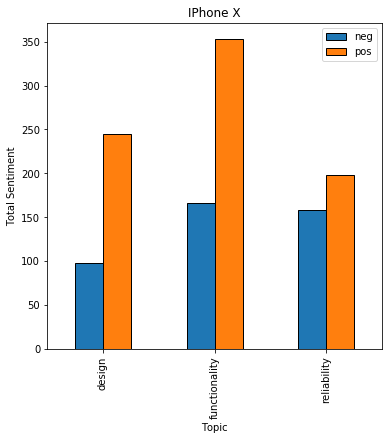

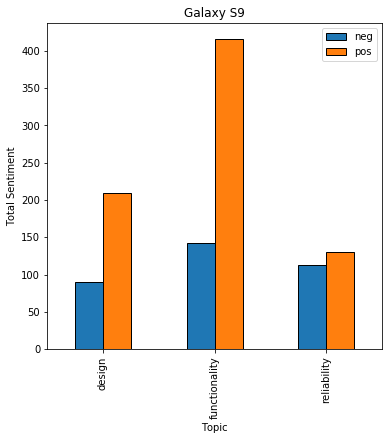

In [96]:
# quick visualization
pd.DataFrame(iphonex_sent).T.plot(kind='bar', edgecolor='k', figsize=(6,6))
plt.xlabel('Topic')
plt.ylabel('Total Sentiment')
plt.title('IPhone X')
plt.show()

# quick visualization
pd.DataFrame(s9_sent).T.plot(kind='bar', edgecolor='k', figsize=(6,6))
plt.xlabel('Topic')
plt.ylabel('Total Sentiment')
plt.title('Galaxy S9')
plt.show()

In [41]:
from collections import defaultdict

lowest = defaultdict()
highest = defaultdict()
for i in iphonex_terms:
    if iphonex_terms[i]:
        highest[i] = iphonex_terms[i].most_common()[:20]
        lowest[i] = iphonex_terms[i].most_common()[-10:]
        
iphonex_highest_df = pd.DataFrame(highest)
iphonex_lowest_df = pd.DataFrame(lowest)

iphonex_highest_df.head()

,design,functionality,reliability
0,"(way, 11)","(camera, 9.0)","(protection, 16)"
1,"(design, 11)","(improvements, 8)","(top, 16)"
2,"(gold, 9.5)","(apps, 6.5)","(performance, 8)"
3,"(improvement, 8)","(option, 5)","(quality, 6)"
4,"(work, 6)","(processor, 5)","(case, 6)"


In [42]:
lowest = defaultdict()
highest = defaultdict()
for i in s9_terms:
    if s9_terms[i]:
        highest[i] = s9_terms[i].most_common()[:20]
        lowest[i] = s9_terms[i].most_common()[-10:]
        
s9_highest_df = pd.DataFrame(highest)
s9_lowest_df = pd.DataFrame(lowest)

s9_highest_df.head()

,design,functionality,reliability
0,"(photos, 12)","(features, 15.5)","(top, 16)"
1,"(display, 9)","(s9, 12.5)","(charging, 4.25)"
2,"(way, 8)","(phones, 12)","(deal, 4)"
3,"(colors, 8)","(scan, 12)","(life, 4)"
4,"(light, 7)","(screen, 9)","(success, 4)"


In [43]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0,1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
        
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    
    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

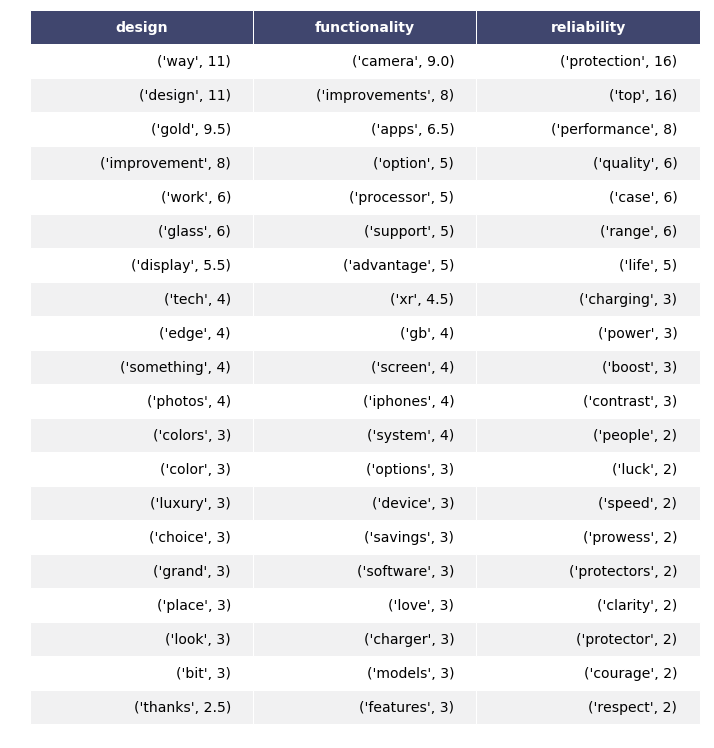

In [44]:
render_mpl_table(iphonex_highest_df, header_columns=0, col_width=4.0)

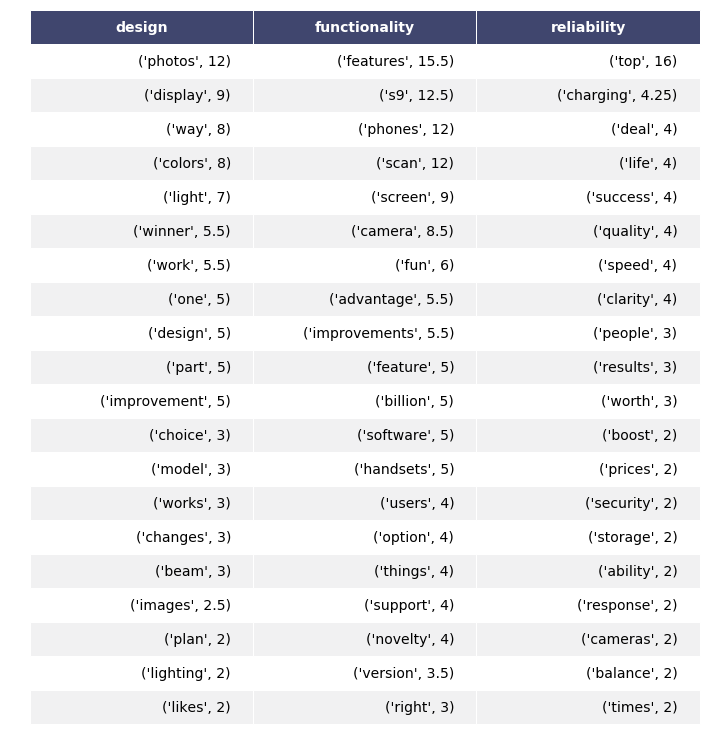

In [45]:
render_mpl_table(s9_highest_df, header_columns=0, col_width=4.0)

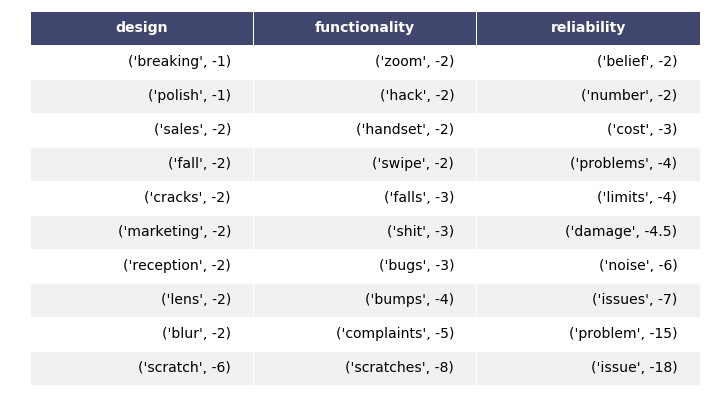

In [46]:
render_mpl_table(iphonex_lowest_df, header_columns=0, col_width=4.0)

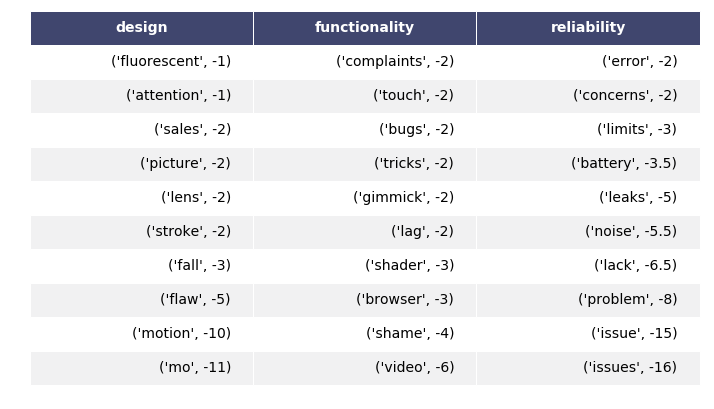

In [47]:
render_mpl_table(s9_lowest_df, header_columns=0, col_width=4.0)

In [48]:
df_iphonex = pd.DataFrame(iphonex_sent).T

df_iphonex["total"] = df_iphonex.neg + df_iphonex.pos
df_iphonex["neg_norm"] = df_iphonex.neg/(df_iphonex.neg + df_iphonex.pos)
df_iphonex["pos_norm"] = df_iphonex.pos/(df_iphonex.neg + df_iphonex.pos)
df_iphonex["pos/neg"] = (df_iphonex.pos/df_iphonex.neg)

df_iphonex

,neg,pos,total,neg_norm,pos_norm,pos/neg
design,97.5,245.0,342.5,0.284672,0.715328,2.512821
functionality,166.0,353.5,519.5,0.319538,0.680462,2.129518
reliability,158.0,198.5,356.5,0.443198,0.556802,1.256329


In [49]:
df_s9 = pd.DataFrame(s9_sent).T

df_s9["total"] = df_s9.neg + df_s9.pos
df_s9["neg_norm"] = df_s9.neg/(df_s9.neg + df_s9.pos)
df_s9["pos_norm"] = df_s9.pos/(df_s9.neg + df_s9.pos)
df_s9["pos/neg"] = (df_s9.pos/df_s9.neg)

df_s9

,neg,pos,total,neg_norm,pos_norm,pos/neg
design,90.0,209.50,299.50,0.300501,0.699499,2.327778
functionality,143.0,416.50,559.50,0.255585,0.744415,2.912587
reliability,113.5,130.25,243.75,0.465641,0.534359,1.147577


In [50]:
# # Create list of texts
# iphone_reviews = df[df['phone']=='IPhone X']
# iphonex = list(iphone_reviews.text)

# s9_reviews = df[df['phone']=='Samsung Galaxy S9']
# s9 = list(s9_reviews.text)

# # Join the list into one string of texts
# iphonex = ' '.join(iphonex)
# s9 = ' '.join(s9)

# iphonex_aspect_sentiment_scores = dict(feature_sentiment(iphonex))
# s9_ascpect_sentiment_scores = dict(feature_sentiment(s9))

# Output

In [51]:
# # Create sorted dataframe of phone aspects and their sentiment scores
# iphonex = pd.DataFrame.from_dict(iphonex_aspect_sentiment_scores, orient='index')
# iphonex['score'] = iphonex[0]
# iphonex['aspects'] = iphonex.index
# iphonex = iphonex.sort_values(by=['score'], ascending=False)
# iphonex = iphonex.reset_index()
# iphonex = iphonex.drop([0, 'index'], axis=1)
# iphonex = iphonex.reindex(sorted(iphonex.columns), axis=1)

# s9 = pd.DataFrame.from_dict(s9_ascpect_sentiment_scores, orient='index')
# s9['score'] = s9[0]
# s9['aspects'] = s9.index
# s9 = s9.sort_values(by=['score'], ascending=False)
# s9 = s9.reset_index()
# s9 = s9.drop([0, 'index'], axis=1)
# s9 = s9.reindex(sorted(s9.columns), axis=1)

In [52]:
# # Separate dataframes from positive and negative aspects for each phones

# # IPhoneX
# iphonex_negative = iphonex[iphonex['score']<0]
# iphonex_negative['negative aspects'] = iphonex_negative['aspects']
# iphonex_negative = iphonex_negative.sort_values(by=['score'], ascending=True)
# iphonex_negative = iphonex_negative.reset_index()
# iphonex_negative = iphonex_negative.drop(['index', 'aspects'], axis=1)
# iphonex_negative = iphonex_negative.reindex(sorted(iphonex_negative), axis=1)

# iphonex_positive = iphonex[iphonex['score']>0]
# iphonex_positive['positive aspects'] = iphonex_positive['aspects']
# iphonex_positive = iphonex_positive.reset_index()
# iphonex_positive = iphonex_positive.drop(['index', 'aspects'], axis=1)
# iphonex_positive = iphonex_positive.reindex(sorted(iphonex_positive), axis=1)


# # s9
# s9_negative = s9[s9['score']<0]
# s9_negative['negative aspects'] = s9_negative['aspects']
# s9_negative = s9_negative.sort_values(by=['score'], ascending=True)
# s9_negative = s9_negative.reset_index()
# s9_negative = s9_negative.drop(['index', 'aspects'], axis=1)
# s9_negative = s9_negative.reindex(sorted(s9_negative), axis=1)

# s9_positive = s9[s9['score']>0]
# s9_positive['positive aspects'] = s9_positive['aspects']
# s9_positive = s9_positive.reset_index()
# s9_positive = s9_positive.drop(['index', 'aspects'], axis=1)
# s9_positive = s9_positive.reindex(sorted(s9_positive), axis=1)

# # Combine positive and negative features side-by-side
# s_9 = pd.DataFrame()
# s_9['positive aspects'] = s9_positive['positive aspects']
# s_9['positive score'] = s9_positive['score']
# s_9['negative aspects'] = s9_negative['negative aspects']
# s_9['negative score'] = s9_negative['score']

# iphone_x = pd.DataFrame()
# iphone_x['positive aspects'] = iphonex_positive['positive aspects']
# iphone_x['positive score'] = iphonex_positive['score']
# iphone_x['negative aspects'] = iphonex_negative['negative aspects']
# iphone_x['negative score'] = iphonex_negative['score']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

# IPhone X

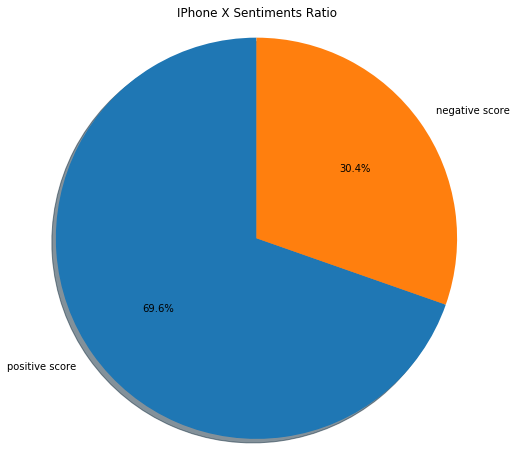

In [54]:
# # Create Pie Chart showing ratio of positive to negative aspects

# iphonex_positive_count = iphone_x['positive score'].sum()
# iphonex_negative_count = ((-1)*iphone_x['negative score'].sum())
# iphonex_ratio = [iphonex_positive_count, iphonex_negative_count]
# labels = 'positive score', 'negative score'

# fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
# ax.pie(iphonex_ratio, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.set_title("IPhone X Sentiments Ratio")
# plt.show()

# Samsung Galaxy S9

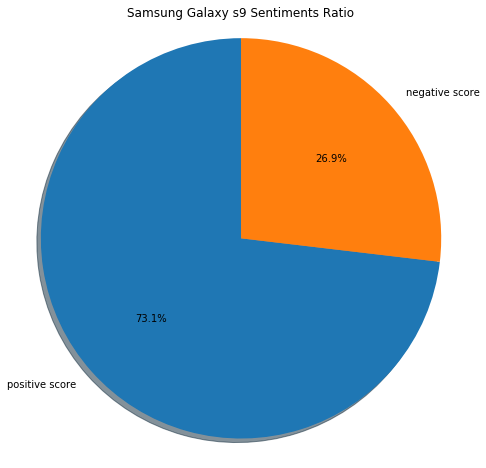

In [56]:
# # Create Pie Chart showing ratio of positive to negative aspects

# s9_positive_count = s_9['positive score'].sum()
# s9_negative_count = ((-1)*s_9['negative score'].sum())
# iphonex_ratio = [s9_positive_count, s9_negative_count]
# labels = 'positive score', 'negative score'

# fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
# ax.pie(iphonex_ratio, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.set_title("Samsung Galaxy s9 Sentiments Ratio")
# plt.show()

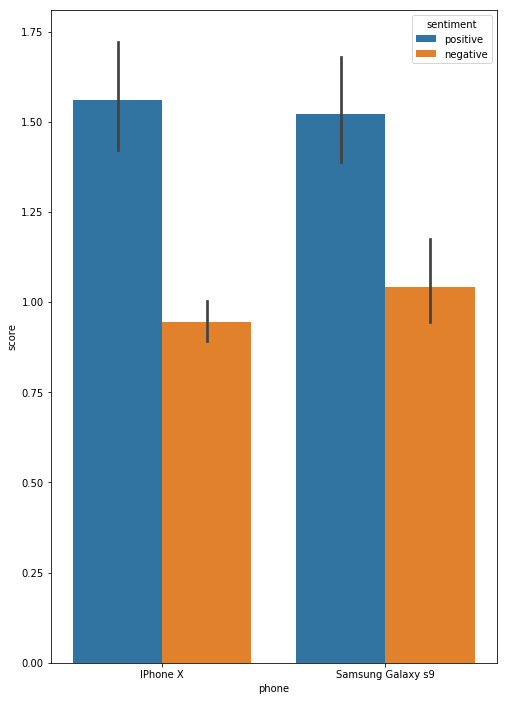

In [58]:
# # Barplot comparing the positive and negative sentiments of of both phones
# iphonex['phone'] = 'IPhone X'
# s9['phone'] = 'Samsung Galaxy s9'

# frames = [iphonex, s9]
# both_phones = pd.concat(frames)
# both_phones['sentiment'] = np.where(both_phones['score']>0, 'positive', 'negative')

# both_phones['score'] = both_phones['score'].apply(lambda x: (x**2))
# both_phones['score'] = both_phones['score'].apply(lambda x: (math.sqrt(x)))

# fig, ax = plt.subplots(figsize=(8,12))
# ax = sns.barplot(x="phone", y="score", hue="sentiment", data=both_phones)

In [60]:
# Label all the axes in bar graphs
# Add black line frame for betweer separation in ALL graphs


# Give Render mpl table clear titles
# Reorder lowest_dfs to ascending so that the worst aspects are at the top

# Recreate pie charts and bar charts using pos:neg ratios in topic grouped model


# Remove some extra words you see in render tables that don't mean anything
# Rename "functionality" to "function" 

In [59]:
# Visualizations
    # Research
    # impliment
        # Plots that a friendly to end users
        # Visually Aesthetic
        # Insightful
        # Lots of coherent information
        
# Organize Code, Write report, Complete Notebook

# Create Presentation

# Turn in Notebook

# Schedule Technical Take Home and Interview